In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [12]:
url = 'https://query1.finance.yahoo.com/v7/finance/download/%5ENSEI?period1=1557468002&period2=1589090402&interval=1d&events=history'
input_file=pd.read_csv(url, header=0, parse_dates=True, index_col='Date') # header=0 takes the first line as column headers
input_file= input_file.dropna(how='any') #to drop NaN rows and columns
input_file.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-10,11314.150391,11345.799805,11251.049805,11278.900391,11278.900391,387300.0
2019-05-13,11258.700195,11300.200195,11125.599609,11148.200195,11148.200195,357600.0
2019-05-14,11151.650391,11294.750000,11108.299805,11222.049805,11222.049805,398100.0
2019-05-15,11271.700195,11286.799805,11136.950195,11157.000000,11157.000000,414200.0
2019-05-16,11180.349609,11281.549805,11143.349609,11257.099609,11257.099609,350700.0


### Simple Moving Average

In [19]:
input_file['SMA50']= input_file['Close'].rolling(50).mean()
input_file['SMA10']=input_file['Close'].rolling(10).mean()

Text(0.5, 1.0, 'Simple Moving Average')

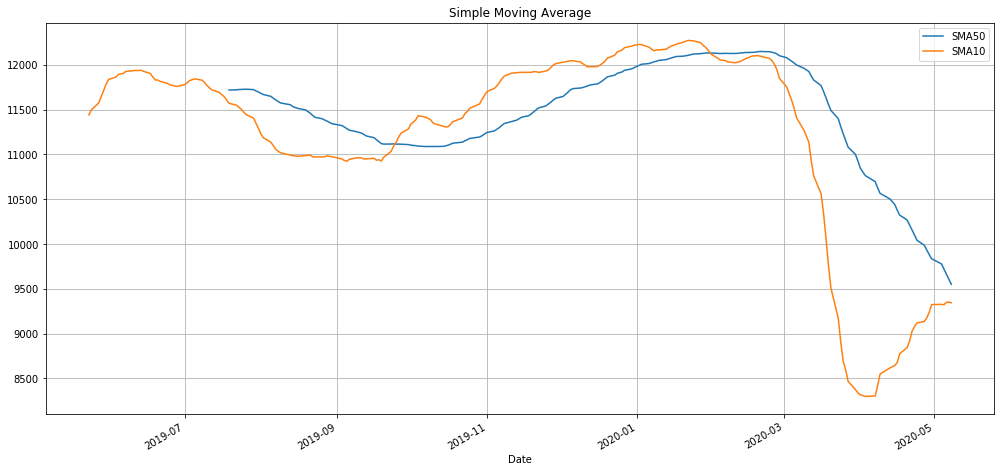

In [22]:
ax=input_file['SMA50'].plot(legend=True)
input_file['SMA10'].plot(ax=ax,figsize=(17,8),legend=True)
plt.grid(True)
plt.title('Simple Moving Average')

In [23]:
input_file['pos_indicator']=(input_file['SMA10']>input_file['SMA50']) & (input_file['SMA50'].shift(1)>=input_file['SMA10'].shift(1))
input_file['neg_indicator']=(input_file['SMA10']<input_file['SMA50']) & (input_file['SMA50'].shift(1)<=input_file['SMA10'].shift(1))
input_file['Indicator']=[1 if input_file.loc[ei,'pos_indicator']|input_file.loc[ei,'neg_indicator'] 
                        else 0 for ei in input_file.index]

crossover=input_file['Indicator']==1
input_file[crossover]

,Open,High,Low,Close,Adj Close,Volume,SMA50,SMA10,pos_indicator,neg_indicator,Indicator,Sum,Mean_Return_NXT_10D
Date,,,,,,,,,,,,,
2019-09-25,11564.849609,11564.950195,11416.099609,11440.200195,11440.200195,600.0,11114.363008,11132.805078,True,False,1,-1016.000972,0.008881
2020-01-31,12100.400391,12103.549805,11945.849609,11962.099609,11962.099609,771300.0,12131.575000,12123.209863,False,True,1,1020.706059,0.008533


### Mean Absolute Return for the next 10 days

In [15]:
input_file['Sum']=0
for j in range(1,11):
    input_file['Sum']+=((input_file['Close'].shift(-j))-input_file['Close'])
input_file['Mean_Return_NXT_10D']=abs(input_file['Sum']/(input_file['Close']*10))
input_file.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA50,SMA10,pos_indicator,neg_indicator,Indicator,Sum,Mean_Return_NXT_10D
Date,,,,,,,,,,,,,
2020-05-04,9533.500000,9533.500000,9266.950195,9293.500000,9293.500000,687500.0,9777.798027,9326.885059,False,False,0,NaN,NaN
2020-05-05,9429.400391,9450.900391,9190.750000,9205.599609,9205.599609,725200.0,9719.641016,9321.260059,False,False,0,NaN,NaN
2020-05-06,9226.799805,9346.900391,9116.500000,9270.900391,9270.900391,722200.0,9664.143027,9350.205078,False,False,0,NaN,NaN
2020-05-07,9234.049805,9277.849609,9175.900391,9199.049805,9199.049805,708700.0,9608.274024,9351.380078,False,False,0,NaN,NaN
2020-05-08,9376.950195,9382.650391,9238.200195,9251.500000,9251.500000,609100.0,9550.786016,9345.140039,False,False,0,NaN,NaN


In [16]:
keep_df=input_file[['Close','Mean_Return_NXT_10D','Indicator']] 
#slices the DataFrame: to drop last 10 columns
final_df=keep_df[:-10].round({'Close':2,'Mean_Return_NXT_10D':3})

### OLS Linear Regression.
Indicator as the independent variable and
mean absolute return for the next 10 days (dependent variable)

In [17]:
Y=final_df['Mean_Return_NXT_10D']
dropped=final_df.drop(columns=['Close','Mean_Return_NXT_10D'])
X=dropped

In [18]:
regr = linear_model.LinearRegression()
res = regr.fit(X, Y)
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                            
Dep. Variable:     Mean_Return_NXT_10D   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                 -0.003
Method:                  Least Squares   F-statistic:                    0.3649
Date:                 Sun, 28 Jun 2020   Prob (F-statistic):              0.546
Time:                         12:46:57   Log-Likelihood:                 487.65
No. Observations:                  233   AIC:                            -971.3
Df Residuals:                      231   BIC:                            -964.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0219      0.002     11.08